## Introduction

논문: [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)

코드: [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

참고 블로그: [[1]](https://theaisummer.com/vision-transformer/),[[2]](https://velog.io/@changdaeoh/Vision-Transformer-Review), [[3]](https://simonezz.tistory.com/102)

Self-attention기반의 구조들은 발표 이후 자연어 처리분야에서 기존의 RNN을 대체하여 대세로 자리잡았다. 특히 큰 텍스트 코퍼스에서 사전 학습하고 작은 task-specific dataset에서 fine-tuning 하는 BERT와 같은 방식은 언어처리의 표준이 되고 있다.  트랜스포머의 계산효율성과 확장성(scalability)덕에 전례없는 사이즈의 모델(천억개 이상의 파라미터를 갖는)을 훈련하는 것이 가능해졌다. 

하지만, 비전분야에서는 Convolutional 구조가 아직까지 우세하게 사용되고 있다. NLP에서의 성공에 영감을 받아서 다양한 연구에서 CNN 같은 구조를 self-attention과 결합하려고 시도해왔는데, 가장 최근의 모델들은 이론상으로는 효과적이었지만, 특수한 어텐션 패턴 사용 때문에 현대 하드웨어 가속기에서 효과적으로 스케일링이 불가능했다. 

 - ELCTRA 등의 모델에서 BERT의 계산 효율성을 문제삼아 개선된 모델을 냄

 
NLP에서의 트랜스포머 이러한 성공을 본보기 삼아 Vison 분야에서 트렌스포머 적용을 시도하는 작업을 수행하였다. 기존에 , 이 논문에서는 standard transformer를 최소한의 수정으로 직접 이미지에 적용하는 것에 대해 실험을 했다. 이를 위해, 이미지를 패치별로 쪼개고 (이미지 패치들은 NLP에서의 token과 같은 방식으로 다뤄지게 된다.), 이러한 패치들의 linear embeddings sequence를 트랜스포머에 input으로 넣었다.

이 모델을 supervised 방식으로 이미지 분류에 학습을 시켜 실험하였다.

ImageNet과 같은 중간 사이즈의 데이터셋에서 학습했을 때, 모델은 ResNet보다 약간 낮은 수치의 정확도를 보여줬는데, 이는 트랜스포머가 CNN에 내재되어 있는 inductive biases(translation equivariance and locality)가 부족함을 의미한다. 이 때문에 중간 사이즈의 데이터셋은 이 모델을 학습시키기에 충분하지가 않음을 알 수 있다.

하지만, 모델이 더 큰 데이터셋에서 학습되었을 때는 다른 양상을 보여주는데, 큰 스케일의 학습이 inductive bias를 이겨버리는 것을 알 수 있었다. ViT가 충분한 스케일의 데이터셋에서 사전학습되고 task로 전이 학습될 때 훌륭한 결과를 보여줬기 때문이다.

```
 Inductive biase
기계학습에서의 inductive bias는, 학습 모델이 지금까지 만나보지 못했던 상황에서 정확한 예측을 하기 위해 사용하는 추가적인 가정을 의미
```
![table](https://blog.kakaocdn.net/dn/bLG5lV/btqUEAsjnkd/jh9ehJAbtDOYNWerjxkfZ0/img.png)
```
여기서 Conv 같은 경우 Locality에 대한 가정이 있음 
Convolution을 처리하는 과정을 보면 Local(지역적인) 영역에서 Spatial한 정보를 잘 뽑아냄
이러한 모델 설계자체에 가정이들어감

"Vision Task는 지역적으로 정보를 얻을게 많다!"
 
RNN 또한 추가적인 가정이 들어 가 시계열적 나열에서 가까운 애들한테 더 많은 영향을 주거나 받을 수 있게 설계
```

모델이 거대한 데이터 셋(14M ~ 300M장)에 대해 훈련되는 경우 양상이 변하는데, 저자들은 대규모의 훈련이 모델의 inductive bias를 찍어누를 수 있다는 것을 확인하였는데, ViT가 충분히 큰 데이터에 사전훈련된 이후 더 작은 데이터 셋에 대해 전이되어 학습이 이루어 질 때 기존 SotA모델들의 성능에 필적하거나 혹은 능가하는 훌륭한 결과를 냈다고 한다.



## Related Work
트랜스포머가 2017년 Vaswani에 의해 machine translation 분야에서 제안되었고, 많은 NLP task에서 sota가 되었다.
대규모의 트랜스포머 기반 모델들은 자주 대규모 말뭉치에 pre-train 된 후에 당면한 과제에 맞게 fine-tuning 되었다. BERT는 denoising self-supervised을, GPT는 language modeling을 pre-training task로써 활용하였다.

이미지에 대한 self-attention의 단순한 적용은 각 픽셀이 다른 모든 픽셀들에 attend 될 것을 요구한다. 그리고 이는 픽셀 수에 대해 quadratic한 복잡도를 갖으며, 이로인해 현실적인 다양한 input size에 확장될 수 없다. 그리하여 트랜스포머를 image processing에 적용시키기 위해서 몇가지 근사(approximation)방법들이 시도되어왔다.
( local self-attention, sparse attention, applying it in blocks of varying size 등)
이러한 많은 specialized attention 구조들은 컴퓨터 비전 task에서 유망한 결과를 보여주나,
하드웨어 가속기에서 효율적으로 구현되기 위해서는 복잡한 엔지니어링이 필요하다.

CNN과 self-attention을 결합하는데도 많은 관심이 기울여져왔다. self-attention을 이용하여 feature map들을 augmenting한다던지, CNN의 output을 추가적으로 더 처리한다던지...

연구진들은 전체 크기의 이미지(full-sized image)에 대해 global self-attention을 수행하는 transformer의 적용 사례는 없다고 주장하고있으며, 그들이 본 논문에서 소개할 모델과 가장 가까운 것은 iGPT라고 한다. iGPT는 이미지의 해상도와 color space를 줄인뒤 image pixel들에 transformer를 적용한 모델이며, 하나의 generative model로써 비지도 방식으로 훈련되었으며, 그로부터 얻어진 representation은 분류를 위해 fine-tuning 되거나 선형탐색될 수 있으며 이미지넷에서 최대정확도 72%를 기록했다고 한다.

본 연구는 최근 증가하는 "표준 ImageNet 데이터셋보다 더 대규모의 이미지 recognition 데이터셋에 대한 탐구"에 관한 논문들에 결을 같이한다고 볼 수 있다. 추가적인 데이터소스의 사용은 표준 벤치마크들에서 sota의 결과를 달성하게한다는 연구들이 있으며, 더 나아가 CNN의 성능이 데이터셋 size에 따라 어떻게 달라질 수 있는지에 대한 연구와 대규모 데이터셋(ImageNet-21k, JFT-300M)에 대한 CNN의 전이학습을 경험적으로 탐구하는 연구도 있었다.
본 연구는 바로 위에 언급된 두 데이터셋에 초점을 맞추고있으나 이전의 연구들에서 사용한 ResNet 기반 모델들 대신 Transformer를 사용하여 학습을 진행하였다.

In [2]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 24.6 MB/s 


## 라이브러리

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## 데이터 준비

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169017344/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## 모델 구성

![model](https://media.vlpt.us/images/changdaeoh/post/bff7ddf5-4aa7-471d-8574-bdbeeb75ad0d/image.png)

모델에 대한 전반적인 overview는 figure 1과 같다. 표준 트랜스포머는 1차원 토큰 임베딩 시퀀스를 input으로써 받는다. 모델 내부에서 2차원 image를 다루기 위해, 본래에 3차원인 이미지 x∈R 
H×W×C
 를 2차원의 패치들 x 
p
​
 ∈R 
N×(P<sup>2</sup>
 ⋅C)
 로 flatten 하였다. (H, W)는 원본이미지의 해상도이며, C는 이미지의 채널 수이고, (P, P)는 패치들의 해상도이다. 이때 N=HW/P 
2
 은 패치의 수를 의미하는데, Transformer Encoder에 input되는 유효 시퀀스 길이(하이퍼파리미터)로써 바라볼 수도 있다. 트랜스포머는 내부의 모든 layer들에 흐르는 latent vector의 size가 D로 통일 되어있기 때문에 저자들은 2차원 patch들을 다시 1차원으로 flatten하고(size : NP<sup>2</sup>C) 이를 trainable한 linear projection을 거쳐 D차원 벡터로 매핑시켰다. 본 논문전반에서 이 projection의 결과벡터를 patch embeddings라고 언급한다.


## hyperparameter 구성

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # 72X72 로 이미지 리사이즈
patch_size = 6  # 패치 사이즈
num_patches = (image_size // patch_size) ** 2 # 패치 개수
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # 프로젝션 차원
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

ERT의 [CLS]토큰과 유사하게, 저자들은 임베딩된 패치들의 맨 앞에 하나의 학습가능한 class 토큰 임베딩 벡터를 추가하였다 pre-training시와 fine-tuning시 모두, 이 image representation vector 위에 classification head가 부착된다. clf head는 사전학습 시에는 하나의 은닉층을 가진 MLP로 구현되고, 파인튜닝 시에는 단일 linear layer로 구현된다.

In [7]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [8]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


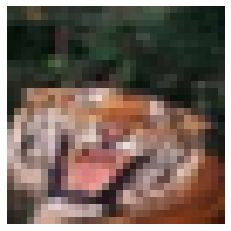

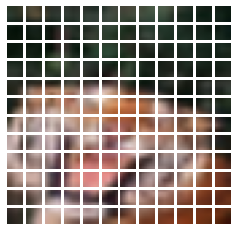

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

위치정보를 유지시키기위하여 patch embeddings에 trainable한 position embeddings이 더해진다. 저자들은 이미지를 위한 advanced한 2D-aware position embedding이 전형적인 1D postion embedding과 비교했을 때, 유의미한 성능향상을 가져다주지 않아 1D 위치임베딩을 사용했다고 한다. 이렇게 구성된 최종 임베딩 벡터들의 시퀀스가 encoder에 인풋된다.

In [10]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

트랜스포머 인코더는 multiheaded self-attention(MSA) layer들과 MLP 블록들이 교차되어 구성된다. Layernormalization이 모든 block의 전에 적용되며, residual connection이 모든 블록 이후에 붙는다. MLP는 GELU(Gaussian Error Linear Unit)를 activation으로 사용하는 2개의 layer를 포함하여 구성된다.

![model](https://media.vlpt.us/images/changdaeoh/post/8259c598-8f01-4e3b-b8a5-3bae7c69de82/image.png)



In [11]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
176/176 [==============================] - 2382s 13s/step - loss: 4.4697 - accuracy: 0.0452 - top-5-accuracy: 0.1605 - val_loss: 3.9162 - val_accuracy: 0.1124 - val_top-5-accuracy: 0.3086
Epoch 2/100
176/176 [==============================] - 2367s 13s/step - loss: 3.9404 - accuracy: 0.0983 - top-5-accuracy: 0.2907 - val_loss: 3.5807 - val_accuracy: 0.1596 - val_top-5-accuracy: 0.4066
Epoch 3/100
 95/176 [===============>..............] - ETA: 17:33 - loss: 3.7317 - accuracy: 0.1259 - top-5-accuracy: 0.3529

100 에포크 후에 ViT 모델은 약 55%의 정확도를 달성하고
테스트 데이터의 82% 상위 5개 정확도 달성함. 

14M 이상의 데이터 이상부터 파라미터를 잘 조정하면 SOTA에 근접한 성능 보임
